In [3]:
# %% [1] Imports de las librerias
import os, glob, warnings, joblib, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_curve, precision_recall_curve, classification_report,
    confusion_matrix, precision_score, recall_score, make_scorer
)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

warnings.filterwarnings("default")  
plt.rcParams["figure.dpi"] = 110
RANDOM_STATE = 42

In [4]:
# %% [2] Carga de datos mergeando los fraudes de las variantes
import os, glob
import numpy as np
import pandas as pd

data_dir = "."
base_path = os.path.join(data_dir, "Base.csv")

df_base = pd.read_csv(base_path).replace([np.inf, -np.inf], np.nan)

variant_paths = [p for p in glob.glob(os.path.join(data_dir, "*.csv"))
                 if os.path.basename(p) != "Base.csv"]

variant_dfs = []
for p in variant_paths:
    df = pd.read_csv(p).replace([np.inf, -np.inf], np.nan)
    if "fraud_bool" in df.columns:
        dff = df[df["fraud_bool"] == 1].copy()
        variant_dfs.append(dff)


df = pd.concat([df_base] + variant_dfs, ignore_index=True)

print("Prevalencia global (conteo y ratio):")
vc = df["fraud_bool"].value_counts()
print(vc.to_frame("count").assign(ratio=lambda x: x["count"]/len(df)))
print("Shape total:", df.shape)


Prevalencia global (conteo y ratio):
             count     ratio
fraud_bool                  
0           988971  0.937282
1            66177  0.062718
Shape total: (1055148, 34)


In [9]:
# %% [3] Split 80/20 y features simples
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"].astype(int)

# Dropeamos la columna Origin para evitar posibles fugas de datos
X = X.drop(columns=["origin"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, " Test:", X_test.shape)

# Feature engineering
def add_safe_features(Xd):
    Xd = Xd.copy()
    if set(["income","zip_count_4w"]).issubset(Xd.columns):
        Xd["income_to_zip4w"] = Xd["income"] / (Xd["zip_count_4w"] + 1)
    if set(["customer_age","days_since_request"]).issubset(Xd.columns):
        Xd["age_times_days"] = Xd["customer_age"] * Xd["days_since_request"]
    return Xd

X_train = add_safe_features(X_train)
X_test  = add_safe_features(X_test)



Train: (844118, 33)  Test: (211030, 33)


In [11]:
# %% [4] Columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

print("Numéricas:", len(num_cols), " | Categóricas:", len(cat_cols))


Numéricas: 30  | Categóricas: 5


In [13]:
# %% [5] Imputación antes de SMOTENC para evitar posibles errores
imp_pre = ColumnTransformer([
    ("num_imp", SimpleImputer(strategy="median"), num_cols),
    ("cat_imp", SimpleImputer(strategy="constant", fill_value="missing"), cat_cols)
], remainder="drop")

n_num = len(num_cols)
n_cat = len(cat_cols)
num_idx = list(range(n_num))
cat_idx = list(range(n_num, n_num + n_cat))

cat_mask = [False]*n_num + [True]*n_cat

# Etapa 2: codificación y escala DESPUÉS del SMOTENC
enc_pre = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_idx),                     # escala numéricas
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_idx)              # OHE en categóricas para convertirlo a numeros utilizables
], remainder="drop", sparse_threshold=1.0)


In [15]:
# %% [6] Definición de los modelos
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

log_clf = LogisticRegression(
    penalty="l2", C=1.0, solver="saga",
    max_iter=4000, class_weight=None,
    n_jobs=1, random_state=RANDOM_STATE
)

xgb_clf = XGBClassifier(
    random_state=RANDOM_STATE, eval_metric="logloss",
    n_estimators=200, max_depth=3, learning_rate=0.10,
    subsample=0.9, colsample_bytree=0.9,
    tree_method="hist", n_jobs=1, scale_pos_weight=1.0
)

rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    min_samples_leaf=2, max_features="sqrt",
    n_jobs=1, random_state=RANDOM_STATE, class_weight=None
)


In [17]:
# %% [7] Pipelines SMOTENC + métrica recall@5%FPR
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np



def make_pipe_smote(clf):
    return ImbPipeline([
        ("imp",   imp_pre),
        ("smote", SMOTENC(
            categorical_features=cat_mask,
            sampling_strategy=0.10,
            k_neighbors=3,
            random_state=RANDOM_STATE
        )),
        ("enc",   enc_pre),         
        ("clf",   clf)
    ])


pipelines = {
    "LOGREG": make_pipe_smote(log_clf),
    "XGB"   : make_pipe_smote(xgb_clf),
    "RF"    : make_pipe_smote(rf_clf)
}


In [19]:
# %% [8] Cross-Validation 5-fold
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, make_scorer
from threadpoolctl import threadpool_limits
import numpy as np, gc

def recall_at_5fpr(y_true, y_pred_like, fpr_target=0.05, **kwargs):
    y_score = y_pred_like
    if isinstance(y_score, np.ndarray) and y_score.ndim == 2:
        y_score = y_score[:, -1]

    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
    idx = np.where(fpr <= fpr_target)[0]
    return 0.0 if len(idx) == 0 else float(tpr[idx[-1]])

from sklearn.metrics import make_scorer
recall5_scorer = make_scorer(recall_at_5fpr, needs_proba=True)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "roc_auc": "roc_auc",
    "average_precision": "average_precision",
    "precision": "precision",
    "recall": "recall",
    "recall_5fpr": recall5_scorer
}

cv_means, cv_stds = {}, {}

for name, pipe in pipelines.items():
    print(f"\n‣ Validando modelo: {name}")
    with threadpool_limits(limits=1):
        res = cross_validate(
            pipe, X_train, y_train,
            cv=kfold, scoring=scoring,
            n_jobs=1,                 # Ponemos los folds en serie porque sino el ordenador crashea
            return_train_score=False,
            error_score="raise"
        )
    cv_means[name] = {m.replace("test_", ""): res[m].mean() for m in res if m.startswith("test_")}
    cv_stds[name]  = {m.replace("test_", ""): res[m].std()  for m in res if m.startswith("test_")}
    del res; gc.collect()

print("\nResumen (media ± desv), ordenado por recall@5%FPR:")
header = f"{'Modelo':<8} | {'recall_5fpr':>11} | {'roc_auc':>7} | {'AP':>7} | {'precision':>9} | {'recall':>7}"
print(header)
print("-"*len(header))
for name in sorted(cv_means, key=lambda n: cv_means[n]["recall_5fpr"], reverse=True):
    m, s = cv_means[name], cv_stds[name]
    print(f"{name:<8} | {m['recall_5fpr']:.4f}±{s['recall_5fpr']:.4f} | "
          f"{m['roc_auc']:.4f}±{s['roc_auc']:.4f} | "
          f"{m['average_precision']:.4f}±{s['average_precision']:.4f} | "
          f"{m['precision']:.4f}±{s['precision']:.4f} | "
          f"{m['recall']:.4f}±{s['recall']:.4f}")

best_name = max(cv_means, key=lambda n: cv_means[n]["recall_5fpr"])
best_pipe = pipelines[best_name]
print(f"\nMejor por CV (recall@5%FPR): {best_name} → {cv_means[best_name]['recall_5fpr']:.4f}")





‣ Validando modelo: LOGREG

‣ Validando modelo: XGB

‣ Validando modelo: RF

Resumen (media ± desv), ordenado por recall@5%FPR:
Modelo   | recall_5fpr | roc_auc |      AP | precision |  recall
----------------------------------------------------------------
RF       | 0.5980±0.0058 | 0.9585±0.0011 | 0.8351±0.0037 | 0.9600±0.0014 | 0.5980±0.0058
XGB      | 0.4774±0.0046 | 0.9383±0.0016 | 0.7150±0.0054 | 0.8507±0.0050 | 0.4774±0.0046
LOGREG   | 0.3374±0.0033 | 0.8903±0.0008 | 0.4614±0.0040 | 0.5697±0.0065 | 0.3374±0.0033

Mejor por CV (recall@5%FPR): RF → 0.5980


In [21]:
# %% [9] Selección automática del modelo segun Recall por 5%FPR
best_name = max(cv_means, key=lambda n: cv_means[n]["recall_5fpr"])
best_pipe = pipelines[best_name]
print(f"Mejor modelo por CV (recall@5%FPR): {best_name}  → {cv_means[best_name]['recall_5fpr']:.4f}")


Mejor modelo por CV (recall@5%FPR): RF  → 0.5980


In [23]:
# %% [10] Umbral operativo y entrenamiento final
from sklearn.model_selection import cross_val_predict

with threadpool_limits(limits=1):
    probas_cv = cross_val_predict(
        best_pipe, X_train, y_train,
        cv=kfold, method="predict_proba",
        n_jobs=1                
    )[:, 1]

neg_scores = probas_cv[y_train.values == 0]
thr5 = np.quantile(neg_scores, 1 - 0.05)
print(f"Threshold operativo (FPR≈5% en train): {thr5:.6f}")

best_pipe.fit(X_train, y_train)



Threshold operativo (FPR≈5% en train): 0.154667


Pipeline(steps=[('imp',
                 ColumnTransformer(transformers=[('num_imp',
                                                  SimpleImputer(strategy='median'),
                                                  ['income',
                                                   'name_email_similarity',
                                                   'prev_address_months_count',
                                                   'current_address_months_count',
                                                   'customer_age',
                                                   'days_since_request',
                                                   'intended_balcon_amount',
                                                   'zip_count_4w',
                                                   'velocity_6h',
                                                   'velocity_24h',
                                                   'velocity_4w',
                                                   'bank_branch_count_8w',
                                                   'date_of_birth_d...
                         sampling_strategy=0.1)),
                ('enc',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  StandardScaler(with_mean=False),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [30, 31, 32, 33, 34])])),
                ('clf',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200,
                                        n_jobs=1, random_state=42))])

In [24]:
# %% [11] Evaluación en TEST
y_scores = best_pipe.predict_proba(X_test)[:,1]
y_pred = (y_scores >= thr5).astype(int)

fpr, tpr, thr = roc_curve(y_test, y_scores, drop_intermediate=False)
recall_at_thr = recall_score(y_test, y_pred)
precision_at_thr = precision_score(y_test, y_pred)

def recall_at_5fpr_curve(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score, drop_intermediate=False)
    idx = np.where(fpr <= 0.05)[0]
    return 0.0 if len(idx)==0 else tpr[idx[-1]]
recall5_via_curve = recall_at_5fpr_curve(y_test, y_scores)

print("\n========== MÉTRICAS FINALES (TEST) ==========")
print(f"FPR objetivo (train): 5%  | Umbral usado: {thr5:.6f}")
print(f"Precision@thr (TEST): {precision_at_thr:.4f}")
print(f"Recall@thr    (TEST): {recall_at_thr:.4f}")
print(f"Recall@5%FPR  (curve, TEST): {recall5_via_curve:.4f}")

print("\nClassification report @thr:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)



========== MÉTRICAS FINALES (TEST) ==========
FPR objetivo (train): 5%  | Umbral usado: 0.154667
Precision@thr (TEST): 0.5485
Recall@thr    (TEST): 0.8486
Recall@5%FPR  (curve, TEST): 0.8519

Classification report @thr:
              precision    recall  f1-score   support

           0     0.9895    0.9533    0.9710    197795
           1     0.5485    0.8486    0.6664     13235

    accuracy                         0.9467    211030
   macro avg     0.7690    0.9009    0.8187    211030
weighted avg     0.9618    0.9467    0.9519    211030

Matriz de confusión:
 [[188552   9243]
 [  2004  11231]]


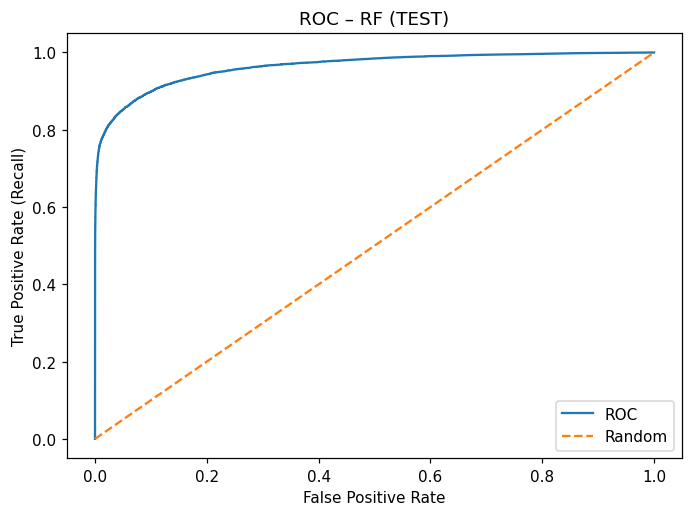

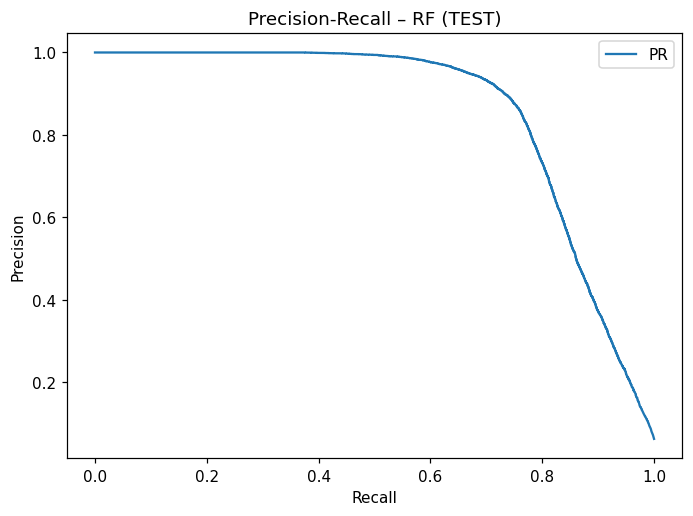

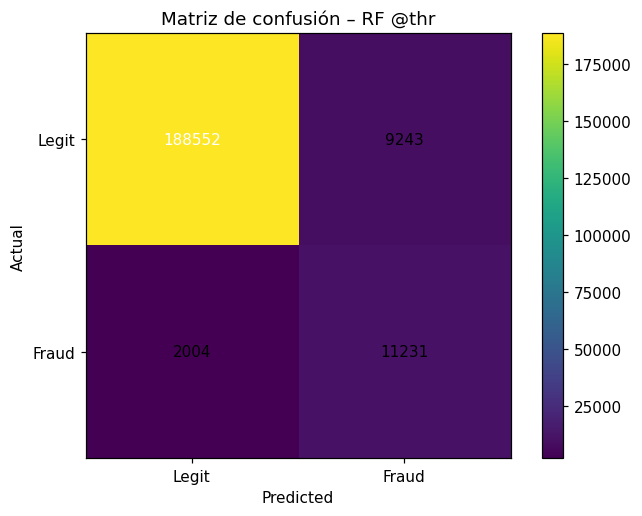

In [25]:
# %% [12] Gráficas
# ROC
plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC – {best_name} (TEST)")
plt.legend()
plt.tight_layout()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_scores)
plt.figure()
plt.plot(rec, prec, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall – {best_name} (TEST)")
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap sencillo
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title(f"Matriz de confusión – {best_name} @thr")
plt.colorbar()
plt.xticks([0,1],["Legit","Fraud"])
plt.yticks([0,1],["Legit","Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()


In [30]:
# %% [13] Guardado de artefacto
model_path = f"model_{best_name.lower()}_smotenc.pkl"
artifact = {
    "pipeline": best_pipe,
    "threshold": thr5,
    "metadata": {
        "best_model": best_name,
        "cv_recall_5fpr": float(cv_means[best_name]["recall_5fpr"]),
        "columns": list(X_train.columns),
        "random_state": RANDOM_STATE
    }
}
joblib.dump(artifact, model_path, compress=3)
print(f"Artefacto guardado en → {model_path}")




Artefacto guardado en → model_rf_smotenc.pkl


In [ ]:
# %% [13] Entrenamiento final con el MEJOR modelo por TPR@5%FPR (CV)
best_name = max(cv_means, key=lambda n: cv_means[n]["tpr5"])
best_pipe = pipelines[best_name]
print("Mejor modelo por CV (tpr@5%fpr):", best_name)

t0 = time.time()
best_pipe.fit(X_train, y_train)
print(f"Entrenamiento final listo en {time.time()-t0:.1f}s")

y_scores = best_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thr = roc_curve(y_test, y_scores)
target = 0.05
idx = np.argmin(np.abs(fpr - target))
thr5 = thr[idx] if idx < len(thr) else thr[-1]

tpr_interp = float(np.interp(target, fpr, tpr))

y_pred = (y_scores >= thr5).astype(int)

fp = ((y_pred == 1) & (y_test == 0)).sum()
tn = ((y_pred == 0) & (y_test == 0)).sum()
fpr_real = fp / (fp + tn)

roc_auc = roc_auc_score(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)  
brier = brier_score_loss(y_test, y_scores)

print("\n========== MÉTRICAS FINALES (TEST - Base) ==========")
print(f"TPR@5%FPR (interpolada): {tpr_interp:.4f}")
print(f"FPR real con thr*        : {fpr_real:.4f} (umbral={thr5:.6f})")
print(f"ROC-AUC                  : {roc_auc:.4f}")
print(f"AUC-PR (Avg Precision)   : {ap:.4f}")
print(f"Brier score              : {brier:.6f}")
print("\nClassification report @thr*: \n", classification_report(y_test, y_pred, digits=4))

